# IMPORT LIBRARIES

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import seaborn as sns
import calendar
import csv
import pickle
import time
from datetime import *
import requests
from google.colab import drive
from dateutil.relativedelta import *
drive.mount('/content/drive')

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor



path = "drive/MyDrive/datathon/"

Mounted at /content/drive


# PRÉ-TRAITEMENT DE LA METEO

Les données de la météo sont recceuillies sur Internet via une API. Cette rubrique fait appel à cette API et génère un fichiers csv avec les données qui nous intéressent mises au bon format.
Une fois le fichier csv généré, il n'y a plus besoin d'éxécuter cette rubrique (on a un nombre d'appel limité à l'API par jour)


In [2]:
def get_json_from_api(q = "", date = "", enddate = "", key = "12049d6fa3a24072980230830232801"):
    """
        Fais une requête à l'API
    """

    elem = {"q" : q, 
        "date" : date, #2023-1-28
        "enddate" : enddate,
        "key" : key,
        "format" : "json"}

    link = "https://api.worldweatheronline.com/premium/v1/past-weather.ashx?" + "&".join(["{}={}".format(k,v) for k,v in elem.items() if v != ""])

    s = requests.Session()
    response = s.post(link, allow_redirects = True )
    return response.json()


def get_meteo_data(q, start_date, end_date) :
    """
        Fais toutes les requêtes à l'API nécessaires pour tous les jours (toutes les 3h) de start_date à end_date
    """
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')

    date = start_date
    enddate = min(end_date, date + relativedelta(months = +1) - timedelta(days = 1))

    meteo_data = [] #Chaque élément de la liste correspond à une heure d'un jour. L'API nous fournit que les infos météo toutes les 3h. On fera une interpolation après
                    #A chaque heure de la liste, on aura les infos : "date", "hour", "sunrise", "sunset", "maxtempC", "mintempC", "avgtempC", "totalSnow_cm", "tempC", "precipMM", "visibility"
    
    #En fait, l'API ne peut renvoyer une range de jour que du même mois. Alors, il faut faire une requête pour chaque mois.
    while date < end_date : 
        date_string, enddate_string = date.strftime("%Y-%m-%d"), enddate.strftime("%Y-%m-%d")
        json_data = get_json_from_api(q = q, date = date_string, enddate = enddate_string)
        
        for day in json_data["data"]["weather"] :
            for hour in day["hourly"] :
                hour_data = {}
                hour_data["date"] = day["date"]
                hour_data["hour"] = int(hour["time"])//100
                #Daily features
                hour_data["sunrise"] = day["astronomy"][0]["sunrise"]
                hour_data["sunset"] = day["astronomy"][0]["sunset"]
                hour_data["maxtempC"] = round( float(day["maxtempC"])/30 , 2) #Température en trenteine de température
                hour_data["mintempC"] = round( float(day["mintempC"])/30 , 2) #Température en trenteine de température
                hour_data["avgtempC"] = round( float(day["avgtempC"])/30 , 2) #Température en trenteine de température
                hour_data["totalSnow_cm"] = float(day["totalSnow_cm"])
                #Hourly features
                hour_data["tempC"] = int(hour["tempC"])/30 #Température en trenteine de température
                hour_data["precipMM"] = float(hour["precipMM"])
                hour_data["visibility"] = float(hour["visibility"])/10 #Visibilité est en dizaine de kilomètre

                meteo_data.append(hour_data)

                meteo_daily_features = ["sunrise", "sunset", "maxtempC", "mintempC", "avgtempC", "totalSnow_cm"]
                meteo_hourly_features = ["tempC", "precipMM", "visibility"]

        date = enddate + timedelta(days = 1)
        enddate = min(end_date, date + relativedelta(months = +1) - timedelta(days = 1))
        
    return meteo_data, meteo_daily_features, meteo_hourly_features


def write_csv(q = "48.869745,2.307946", start_date = "2021-12-1", end_date = "2022-1-1", filename = "meteo_paris.csv") :

    with open(path + filename, 'w', newline='') as file:
        meteo_data, meteo_daily_features, meteo_hourly_features = get_meteo_data(q, start_date, end_date)

        writer = csv.writer(file, delimiter=';')
        writer.writerow(["datetime"] + meteo_daily_features + meteo_hourly_features)

        for i in range(len(meteo_data) - 1) :
            current_data_hour = meteo_data[i]
            next_data_hour = meteo_data[i+1]

            current_hour = datetime.strptime(current_data_hour["date"], '%Y-%m-%d') + timedelta(hours = current_data_hour["hour"])
            next_hour = datetime.strptime(next_data_hour["date"], '%Y-%m-%d') + timedelta(hours = next_data_hour["hour"])
            for j in range(3) : #Ecris current_hour et interpole les hourly features sur les 2 prochaines heures
                row = []
                row.append(current_hour.strftime('%Y-%m-%dT%H:%M:%S') + "+01:00" ) #datetime
                for daily_feature in meteo_daily_features :
                    row.append( current_data_hour[daily_feature] ) #add a daily feature in the row
                for hourly_feature in meteo_hourly_features :
                    row.append( round( current_data_hour[hourly_feature]*(1 - j/3) + next_data_hour[hourly_feature]*j/3 , 2) ) #Interpole linéairement pour le hourly               

                writer.writerow(row)
                current_hour += timedelta(hours = 1)


### Ecris un fichier csv meteo_paris.csv grâce à l'API de worldweatheronline avec les features de météo de Paris qui nous intéressent
write_csv(start_date = "2021-12-1", end_date = "2023-1-29")

Voilà à quoi ressemble le fichier csv généré par `write_csv` :

| datetime                  | sunrise   | sunset   |   maxtempC |   mintempC |   avgtempC |   totalSnow_cm |   tempC |   precipMM |   visibility |
|:--------------------------|:----------|:---------|-----------:|-----------:|-----------:|---------------:|--------:|-----------:|-------------:|
| 2021-12-01 00:00:00+01:00 | 08:23 AM  | 04:56 PM |       0.33 |       0.23 |        0.3 |              0 |    0.23 |       0    |            1 |
| 2021-12-01 01:00:00+01:00 | 08:23 AM  | 04:56 PM |       0.33 |       0.23 |        0.3 |              0 |    0.24 |       0    |            1 |
| 2021-12-01 02:00:00+01:00 | 08:23 AM  | 04:56 PM |       0.33 |       0.23 |        0.3 |              0 |    0.26 |       0    |            1 |
| 2021-12-01 03:00:00+01:00 | 08:23 AM  | 04:56 PM |       0.33 |       0.23 |        0.3 |              0 |    0.27 |       0    |            1 |
| 2021-12-01 04:00:00+01:00 | 08:23 AM  | 04:56 PM |       0.33 |       0.23 |        0.3 |              0 |    0.27 |       0.03 |            1 |

# PREPROCESSING DATA

On importe les données et on ajoute les organise/nettoie

In [3]:
#Importe les données méteo
data_meteo = pd.read_csv(path + "meteo_paris.csv", delimiter = ";")
data_meteo["datetime"] = pd.to_datetime(data_meteo["datetime"], format='%Y-%m-%dT%H:%M:%S%z')
data_meteo = data_meteo.set_index('datetime')

#On limitera chaque secteur à un seul arc délimité par son libel en amont et aval
amont_aval = {"Champs" : ["Av_Champs_Elysees-Washington", "Av_Champs_Elysees-Berri"],
              "Convention" : ["Lecourbe-Convention", "Convention-Blomet"],
              "Peres" : ["Sts_Peres-Voltaire" , "Sts_Peres-Universite"]}

#Import les données (Dec 2021 à Janv 2023)
data_arcs = {"Champs" : pd.read_csv(path + "champs_elysees.csv", delimiter = ";") , 
             "Convention" : pd.read_csv(path + "convention.csv", delimiter = ";"),
             "Peres" : pd.read_csv(path + "sts_peres.csv", delimiter = ";") }

#Quelques transformations pour chaque données
for arc in data_arcs :
    #Ajoute colonne arc
    data_arcs[arc]["Arc"] = arc

    #On se limite qu'à un seul arc par secteur
    data_arcs[arc] = data_arcs[arc][data_arcs[arc]["Libelle noeud amont"] == amont_aval[arc][0]]
    data_arcs[arc] = data_arcs[arc][data_arcs[arc]["Libelle noeud aval"] == amont_aval[arc][1]]

    #On retire quand l'arc est barré
    data_arcs[arc] = data_arcs[arc][data_arcs[arc]["Etat arc"] != "Barré"]

    #Les dates sont données dans des string, on les convertit en type datetime
    data_arcs[arc]["Date et heure de comptage"] = pd.to_datetime(data_arcs[arc]["Date et heure de comptage"], format='%Y-%m-%dT%H:%M:%S%z')

    #On retire des colonnes qui nous servent pas
    data_arcs[arc].drop(['Etat trafic', 
                         'Identifiant arc',
                         'Libelle',
                         "Identifiant noeud amont", 
                         "Libelle noeud amont", 
                         "Identifiant noeud aval", 
                         "Libelle noeud aval", 
                         "Etat arc",
                         "Date debut dispo data",
                         "Date fin dispo data", 
                         "geo_point_2d", "geo_shape"], axis = 1, inplace = True)
    data_arcs[arc] = data_arcs[arc].set_index('Date et heure de comptage')

    #On concatène les données du secteur avec les données météo et drop les NaN
    data_arcs[arc] = pd.concat([data_arcs[arc], data_meteo], axis=1).reset_index().rename(columns={'index': 'Date et heure de comptage'}) #On concatène bien en prenant Date et heure de comptage comme key
    data_arcs[arc].dropna(inplace = True)

#On fusionne les 3 arcs dans dataframe
data = pd.concat(list(data_arcs.values()))

#On trie par ordre chronologique
data.sort_values(by="Date et heure de comptage" , inplace = True)

Voilà à quoi ressemble `data` à ce stade: 

|    | Date et heure de comptage   |   Débit horaire |   Taux d'occupation | Arc        | sunrise   | sunset   |   maxtempC |   mintempC |   avgtempC |   totalSnow_cm |   tempC |   precipMM |   visibility |
|---:|:----------------------------|----------------:|--------------------:|:-----------|:----------|:---------|-----------:|-----------:|-----------:|---------------:|--------:|-----------:|-------------:|
|  4 | 2021-12-01 04:00:00+01:00   |             589 |            17.6739  | Champs     | 08:23 AM  | 04:56 PM |       0.33 |       0.23 |        0.3 |              0 |    0.27 |       0.03 |            1 |
|  4 | 2021-12-01 04:00:00+01:00   |              63 |             0.41278 | Convention | 08:23 AM  | 04:56 PM |       0.33 |       0.23 |        0.3 |              0 |    0.27 |       0.03 |            1 |
|  4 | 2021-12-01 04:00:00+01:00   |              63 |             0.84667 | Peres      | 08:23 AM  | 04:56 PM |       0.33 |       0.23 |        0.3 |              0 |    0.27 |       0.03 |            1 |
|  5 | 2021-12-01 05:00:00+01:00   |              49 |             0.75111 | Peres      | 08:23 AM  | 04:56 PM |       0.33 |       0.23 |        0.3 |              0 |    0.27 |       0.07 |            1 |
|  5 | 2021-12-01 05:00:00+01:00   |             482 |             7.00278 | Champs     | 08:23 AM  | 04:56 PM |       0.33 |       0.23 |        0.3 |              0 |    0.27 |       0.07 |            1 |

On ajoute quelques premières features qu'on aimerait visualiser

In [4]:
### "hours" donne le numéro de l'heure dans l'année
def hour_number(timestamp) :
    return int(timestamp.timetuple().tm_yday - 1)*24 + timestamp.hour
data["hour_number"] = data["Date et heure de comptage"].apply(hour_number)



### "part_day" donne la période de la journée de chaque enregistrement (Matin, aprem, soir, nuit ?)
def part_of_day(timestamp) :
    hour = timestamp.hour
    if 0 <= hour and hour < 6 :
        return "Night"
    elif 6 <= hour and hour < 12 :
        return "Morning"
    elif 12 <= hour and hour < 18 :
        return "After noon"
    else :
        return "Evening"
data["part_day"] = data["Date et heure de comptage"].apply(part_of_day)



### "day_or_night" donne la période de la journée de chaque enregistrement (Matin, aprem, soir, nuit ?)
def day_or_night(timestamp, sunrise, sunset):
    hour = timestamp.hour

    sunset_hour = datetime.strptime(sunset, "%I:%M %p")
    sunset_hour = sunset_hour.hour

    sunrise_hour = datetime.strptime(sunrise, "%I:%M %p")
    sunrise_hour = sunrise_hour.hour

    if sunrise_hour <= hour and hour <= sunset_hour :
        return "Jour"
    return "Nuit"
data["day_or_night"] = data.apply(lambda row : day_or_night(row['Date et heure de comptage'],row['sunrise'], row['sunset']), axis = 1)



#"month" donne le mois de l'enregistrement
def months(timestamp) :
    return calendar.month_name[timestamp.month]
data["month"] = data["Date et heure de comptage"].apply(months)



#"férié" dis si le jour est férié
pd_feries = pd.read_csv(path + "jours_feries_metropole.csv", delimiter = ",")
data_feries = [datetime.strptime(row["date"], '%Y-%m-%d') for index, row in pd_feries.iterrows() ]
def est_ferie(timestamp) :
    if datetime(year = timestamp.year, month = timestamp.month, day = timestamp.day, hour = 0, minute = 0) in data_feries :
        return "Férié"
    return "Pas férié"
data["férié"] = data["Date et heure de comptage"].apply(est_ferie)



#"vacances" dis si le jour est férié
pd_vacances = pd.read_csv(path + "fr-en-calendrier-scolaire.csv", delimiter = ";")
pd_vacances = pd_vacances[pd_vacances["location"] == "Paris"]
pd_vacances = pd_vacances[pd_vacances["annee_scolaire"].str.contains("2021-2022|2022-2023")] #On garde que les dates de ces 2 années
pd_vacances = pd_vacances[pd_vacances["population"] != "Enseignants"] #On veut pas les vacances des enseignants
data_vacances = []
for index, row in pd_vacances.iterrows():
    date_cur = datetime.strptime(row["start_date"].split("+")[0], '%Y-%m-%dT%H:%M:%S')
    end_date = datetime.strptime(row["end_date"].split("+")[0], '%Y-%m-%dT%H:%M:%S')
    while date_cur <= end_date :
        data_vacances.append(date_cur)
        date_cur += timedelta(days = 1)
def est_vacances(timestamp) :
    timestamp_date = datetime(year = timestamp.year, month = timestamp.month, day = timestamp.day, hour = 0, minute = 0, second = 0)
    if timestamp_date in data_vacances :
        return "Vacances"
    else :
        return "Pas vacances"
data["vacances"] = data["Date et heure de comptage"].apply(est_vacances)

À ce stade, voilà à quoi ressemblent les 5 premières lignes de `data` :

|    | Date et heure de comptage   |   Identifiant arc | Libelle           |   Débit horaire |   Taux d'occupation | sunrise   | sunset   |   maxtempC |   mintempC |   avgtempC |   totalSnow_cm |   tempC |   precipMM |   visibility |   hour_number | part_day   | day_or_night   | month    | férié     | vacances     |
|---:|:----------------------------|------------------:|:------------------|----------------:|--------------------:|:----------|:---------|-----------:|-----------:|-----------:|---------------:|--------:|-----------:|-------------:|--------------:|:-----------|:---------------|:---------|:----------|:-------------|
|  4 | 2021-12-01 04:00:00+01:00   |              4264 | AV_Champs_Elysees |             589 |            17.6739  | 08:23 AM  | 04:56 PM |       0.33 |       0.23 |        0.3 |              0 |    0.27 |       0.03 |            1 |          8020 | Night      | Nuit           | December | Pas férié | Pas vacances |
|  5 | 2021-12-01 05:00:00+01:00   |              4264 | AV_Champs_Elysees |             482 |             7.00278 | 08:23 AM  | 04:56 PM |       0.33 |       0.23 |        0.3 |              0 |    0.27 |       0.07 |            1 |          8021 | Night      | Nuit           | December | Pas férié | Pas vacances |
|  6 | 2021-12-01 06:00:00+01:00   |              4264 | AV_Champs_Elysees |             381 |             3.40722 | 08:23 AM  | 04:56 PM |       0.33 |       0.23 |        0.3 |              0 |    0.27 |       0.1  |            1 |          8022 | Morning    | Nuit           | December | Pas férié | Pas vacances |
|  7 | 2021-12-01 07:00:00+01:00   |              4264 | AV_Champs_Elysees |             665 |             6.27    | 08:23 AM  | 04:56 PM |       0.33 |       0.23 |        0.3 |              0 |    0.27 |       0.1  |            1 |          8023 | Morning    | Nuit           | December | Pas férié | Pas vacances |
|  8 | 2021-12-01 08:00:00+01:00   |              4264 | AV_Champs_Elysees |            1028 |             9.145   | 08:23 AM  | 04:56 PM |       0.33 |       0.23 |        0.3 |              0 |    0.27 |       0.1  |            1 |          8024 | Morning    | Jour           | December | Pas férié | Pas vacances |


# DATA VISUALISATION

Visualisons les données pour voir si nous pouvons en tirer des hypothèses.

### Memo :


| Taux d'occupation| +                         | -     |
| ---------------- | ------------------------- | -------- |
| Débit horaire    |                           |          |
| +                |  Beaucoup de voitures, <br /> prend du temps pour traverser <br /> (**Bouchons**) | Beaucoup de voitures, <br /> rapide à traverser <br /> (**Grande voie fluide**) |
| -                |  Pas beaucoup de voitures, <br /> prend du temps pour traverser <br /> (**Petite route ou turbulences** <br /> **inhabituelles)**    | Pas beaucoup de voitures,<br /> rapide à traverser  <br /> (**Route déserte**)  |




Traçons la distribution du débit horaire et du taux d'occupation selon plusieurs catégories (VIOLIN PLOT).

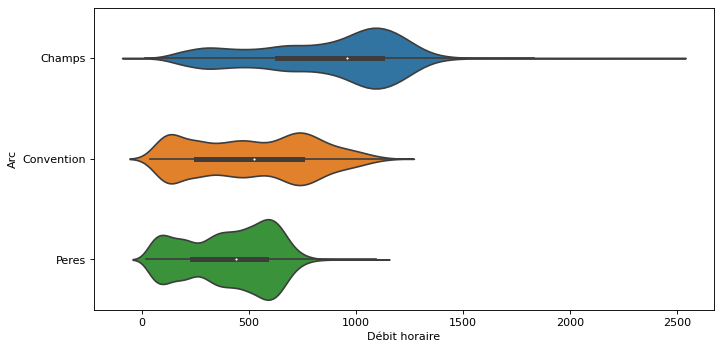

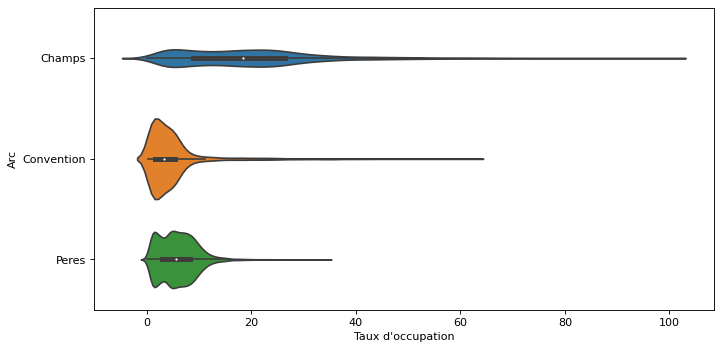

In [15]:
#DH / Arc ############
plt.figure(figsize=(10, 5), dpi=80)
sns.violinplot(data=data, x="Débit horaire", y="Arc")

#TO / Arc
plt.figure(figsize=(10, 5), dpi=80)
sns.violinplot(data=data, x="Taux d'occupation", y="Arc")

### Observations

Les 3 arcs semblent de nature différente. Par exemple, les champs ont tendance à accueillir plus de monde. 

Dorénavant, on ne va plot que la distribution sur l'arc des Champs-Elysées

In [16]:
data_violin = data[data["Arc"] == "Champs"] #On plot que pour champs Elysee pour le reste des graphes

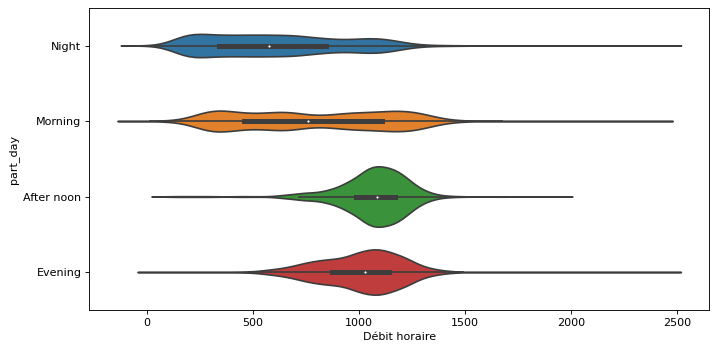

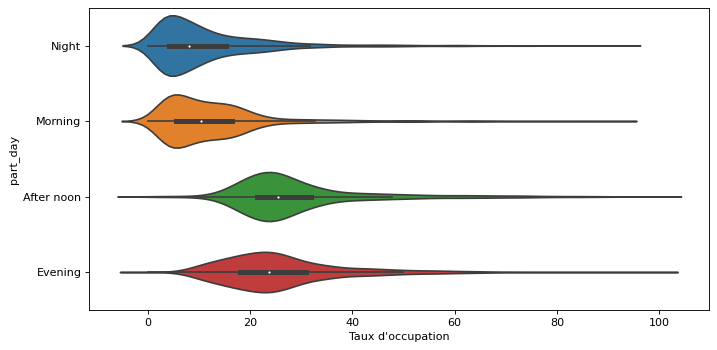

In [17]:
#DH / Part of the day ############
plt.figure(figsize=(10, 5), dpi=80)
sns.violinplot(data=data_violin, x="Débit horaire", y="part_day")

#TO / Part of the day
plt.figure(figsize=(10, 5), dpi=80)
sns.violinplot(data=data_violin, x="Taux d'occupation", y="part_day")

### Observations

Le moment de la journée (et donc l'heure) joue un rôle important. Il semble y a voir plus de monde l'aprem et le soir que la nuit et le matin

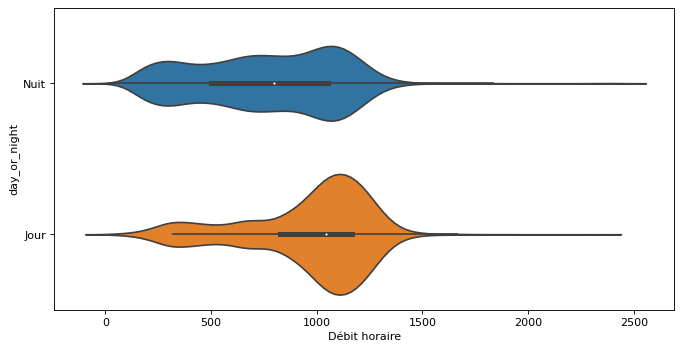

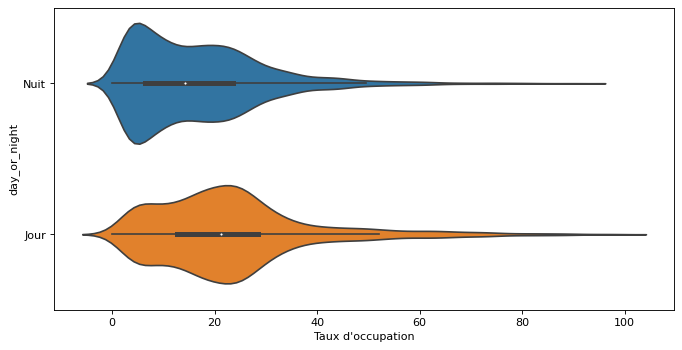

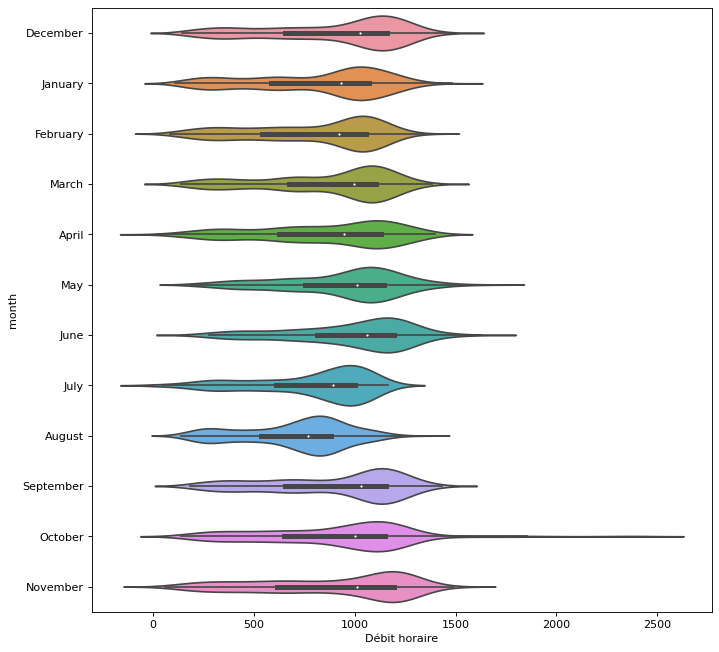

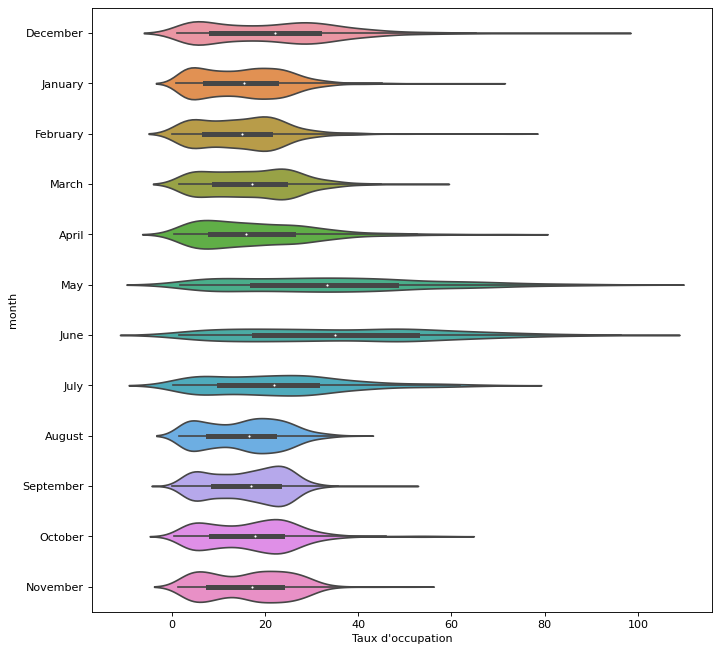

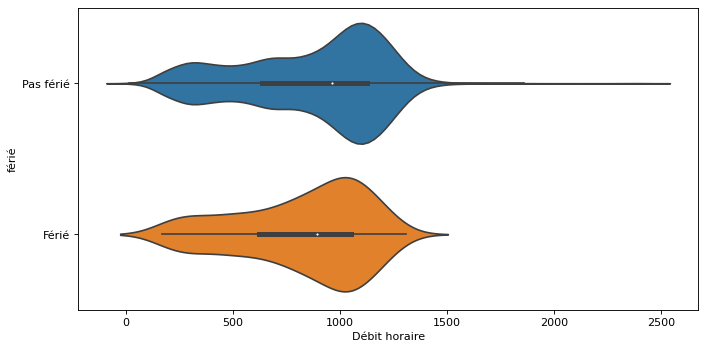

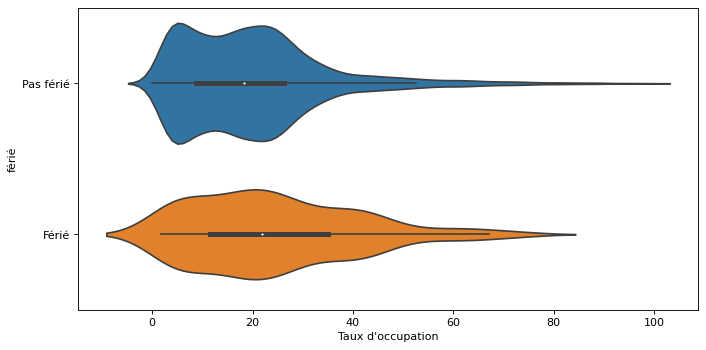

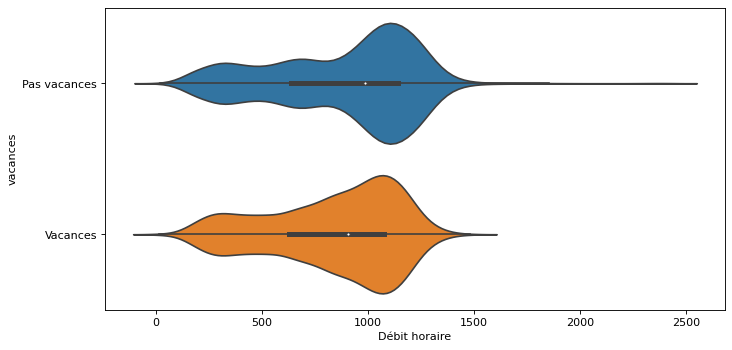

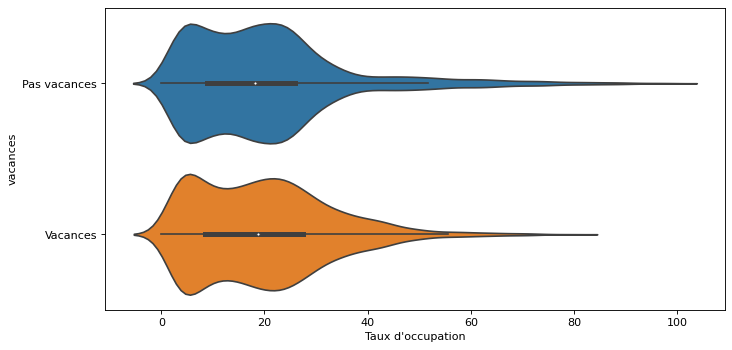

In [19]:
#DH / Day or night ############
plt.figure(figsize=(10, 5), dpi=80)
sns.violinplot(data=data_violin, x="Débit horaire", y="day_or_night")

#TO / Day or night
plt.figure(figsize=(10, 5), dpi=80)
sns.violinplot(data=data_violin, x="Taux d'occupation", y="day_or_night")

#DH / Months ############
plt.figure(figsize=(10, 10), dpi=80)
sns.violinplot(data=data_violin, x="Débit horaire", y="month")

#TO / Months
plt.figure(figsize=(10, 10), dpi=80)
sns.violinplot(data=data_violin, x="Taux d'occupation", y="month")

#DH / Feriés ############
plt.figure(figsize=(10, 5), dpi=80)
sns.violinplot(data=data_violin, x="Débit horaire", y="férié")

#TO / Feriés
plt.figure(figsize=(10, 5), dpi=80)
sns.violinplot(data=data_violin, x="Taux d'occupation", y="férié")

#DH / Vacances ############
plt.figure(figsize=(10, 5), dpi=80)
sns.violinplot(data=data_violin, x="Débit horaire", y="vacances")

#TO / Vacances
plt.figure(figsize=(10, 5), dpi=80)
sns.violinplot(data=data_violin, x="Taux d'occupation", y="vacances")


Voyons comment évolue directement le débit horaire et le taux d'occupation sur l'année 2022 :

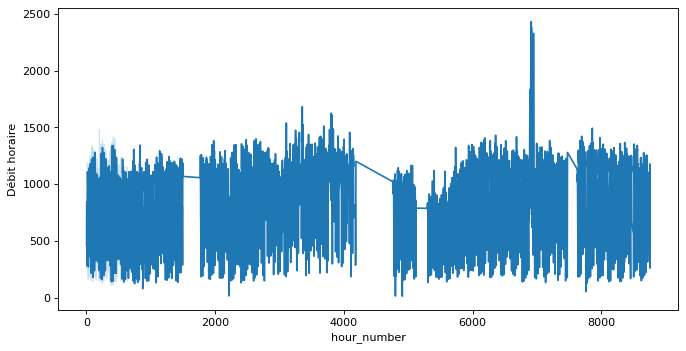

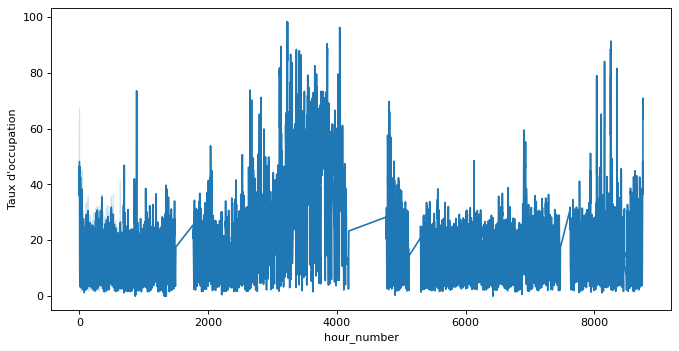

In [20]:
"""
    PLOT TOUT 2022
"""

data_plotline = data[data["Arc"] == "Champs"] #On plot que pour champs Elysee pour le reste des graphes

#Only take the date from 2022
data_from_2022 = data_plotline[data_plotline["Date et heure de comptage"] >= pd.Timestamp("2022-01-01T00:00:00+01:00") ]

plt.figure(figsize=(10, 5), dpi=80)
sns.lineplot(data = data_from_2022[ ["Taux d'occupation", "Débit horaire", "hour_number"] ] , x = "hour_number", y = "Débit horaire")

plt.figure(figsize=(10, 5), dpi=80)
sns.lineplot(data = data_from_2022[ ["Taux d'occupation", "Débit horaire", "hour_number"] ] , x = "hour_number", y = "Taux d'occupation")



Intéressons-nous au moins de Janvier 2022 :

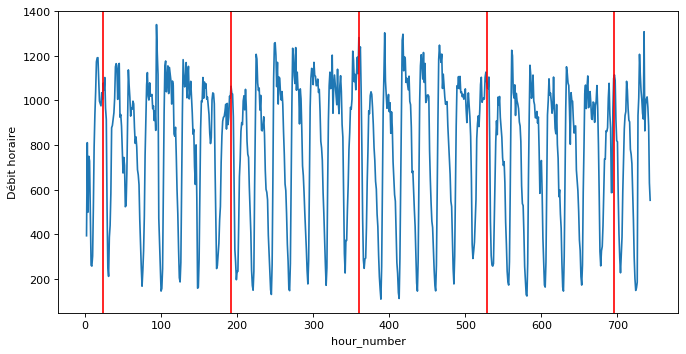

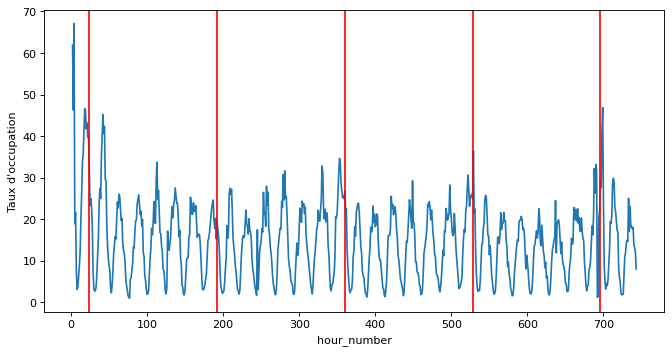

In [21]:
"""
    PLOT QUE JANVIER 2022
"""
data_janv_2022 = data_from_2022[ data_from_2022["Date et heure de comptage"] < pd.Timestamp("2022-02-01T00:00:00+01:00")   ]

plt.figure(figsize=(10, 5), dpi=80)

sns.lineplot(data = data_janv_2022[ ["Taux d'occupation", "Débit horaire", "hour_number"] ] , x = "hour_number", y = "Débit horaire")
#Plot une barre pour chaque dimanche
plt.axvline(24, 0, 1500, color = "red")
plt.axvline(24*7 + 24, 0, 1500, color = "red")
plt.axvline(24*7*2 + 24, 0, 1500, color = "red")
plt.axvline(24*7*3 + 24, 0, 1500, color = "red")
plt.axvline(24*7*4 + 24, 0, 1500, color = "red")

#plt.savefig('janv2022_dh.png', dpi = 3000)


plt.figure(figsize=(10, 5), dpi=80)

sns.lineplot(data = data_janv_2022[ ["Taux d'occupation", "Débit horaire", "hour_number"] ] , x = "hour_number", y = "Taux d'occupation")
plt.axvline(24, 0, 1500, color = "red")
plt.axvline(24*7 + 24, 0, 1500, color = "red")
plt.axvline(24*7*2 + 24, 0, 1500, color = "red")
plt.axvline(24*7*3 + 24, 0, 1500, color = "red")
plt.axvline(24*7*4 + 24, 0, 1500, color = "red")

### Observations

*   **Alternance jour-nuit** : le débit horaire est plus bas la nuit que le jour (y'a personne sur les routes la nuit) et le taux d'occupation aussi (vu qu'il y a personne, les usagers mettent moins de temps à traverser les champs)
*   **Cycles des week-end** : barres rouges = dimanches. Le débit est en moyenne plus élevé le week-end (il y a plus de monde sur les champs le w-e). Le jour de la semaine est un facteur également à prendre en compte



# TRAINING ATTEMPTS

On teste les algos, les features, etc.

### Features

On procède à l'extraction et à la sélection des features. Voici les features que nous avons extraites et choisies :


*   `hour1` et `hour2` : désignent l'heure de l'enregistrement. Ces 2 features sont respectivement des cosinus et sinus pour rendre compte de la périodicité de l'heure. Intuition : cf. étapes de visualtions des données.
*   `weekdays1` et `weekdays2` : désignent le jour de la semaine de l'enregistrement. Idem que précédemment, nous avons utilisé un cosinus/sinus. Intuition : cf. étapes de visualtions des données.
*   `is_day` : vaut 1 si l'enregistrement s'est fait le jour (i.e entre le lever et le coucher du soleil), 0 sinon. Intuition : le manque de visibilité la nuit empêche de rouler trop vite, moins de monde la nuit donc un débit plus faible,...
*   `totalSnow_cm` : épaisseur de neige (en cm) tombée ce jour. Intuition : on roule moins vite quand il neige.
*   `tempC` : température (en trenteine de degré celsius). Intuition : haute température = été donc moins de gens à Paris, beau = vélo donc moins de voitures, froid = neige/pluie (en général) donc moins de visibilité
*   `precipMM` : précipitation en mm tombée ce jour. Intuition : pluie glissante, donc on roule moins vite
*   `visibility` : visibilité horizontale (en dizaine de kilomètre). Intuition : quand la visibilité est mauvaise, on ralentit
*   `is_ferie` : vaut 1 si le jour est férié, 0 sinon. Intuition : moins de travailleurs donc moins de personnes sur les routes
*   `is_vacances` : vaut 1 si Paris (zone C) est en période de vacances, 0 sinon. Intuition : moins de personnes sur Paris donc moins de personnes sur les routes
*   `arc_champs`, `arc_convention` et `arc_peres` : one-hot encoding pour désigner le secteur de l'enregistrement. Intuition : cf. étapes de visualtions des données.

Pour extraire les features, nous avons codé la fonction `features_extraction`. Celle-ci prend les données issues du preprecessing et renvoient la liste des features utilisées ainsi que le dataset avec les features calculées. L'option `split_date` permet de split les données en 2 : une partie avec les enregistrement avant la date `split_date` (pour l'entrainement d'un algo) et une autre partie après (pour tester les performances de l'algo). Ici, nous avons split au 1er janvier 2023. Cela signifie que nous allons entrainé nos algorithmes sur les données de décembre 2021 à décembre 2022 et les tester sur janvier 2023 pour évaluer leur performance.

In [10]:
### FEATURES FUNCTION
def t_hour_1(date):
    return np.sin(date.hour*2*np.pi/24)

def t_hour_2(date):
    return np.cos(date.hour*2*np.pi/24)

def t_day_1(date):
    return np.sin(date.weekday()*2*np.pi/7)

def t_day_2(date):
    return np.cos(date.weekday()*2*np.pi/7)

def is_ferie(str_ferie):
    return int(str_ferie == "Férié")

def is_vacances(str_vac):
    return int(str_vac == "Vacances")

def is_day(str_day) :
    return int(str_day == "Jour")

def arc_champs(str_arc) :
    return int(str_arc == "Champs")

def arc_convention(str_arc) :
    return int(str_arc == "Convention")

def arc_peres(str_arc) :
    return int(str_arc == "Peres")


def features_extraction(raw_data, split_date = None) :


    ### FEATURES EXTRACTION

    features = []

    #HEURE
    raw_data["hour1"] = raw_data["Date et heure de comptage"].apply(t_hour_1)
    raw_data["hour2"] = raw_data["Date et heure de comptage"].apply(t_hour_2)
    features.append("hour1")
    features.append("hour2")

    #JOUR DE LA SEMAINE
    raw_data["weekdays1"] = raw_data["Date et heure de comptage"].apply(t_day_1)
    raw_data["weekdays2"] = raw_data["Date et heure de comptage"].apply(t_day_2)
    features.append("weekdays1")
    features.append("weekdays2")

    #METEO
    raw_data["is_day"] = raw_data["day_or_night"].apply(is_day)
    features.append("is_day")
    #features.append("maxtempC")
    #features.append("mintempC")
    #features.append("avgtempC") 
    features.append("totalSnow_cm") 
    features.append("tempC")
    features.append("precipMM") 
    features.append("visibility")

    #FERIE ET VACANCES
    raw_data["is_ferie"] = raw_data["férié"].apply(is_ferie)
    raw_data["is_vacances"] = raw_data["vacances"].apply(is_vacances)
    features.append("is_ferie")
    features.append("is_vacances")
    
    #ARCS (One-hot code)
    raw_data["arc_champs"] = raw_data["Arc"].apply(arc_champs)
    raw_data["arc_convention"] = raw_data["Arc"].apply(arc_convention)
    raw_data["arc_peres"] = raw_data["Arc"].apply(arc_peres)
    features.append("arc_champs")
    features.append("arc_convention")
    features.append("arc_peres")



    #Only keep features and target
    raw_data = raw_data[["Débit horaire", "Taux d'occupation", "Date et heure de comptage", "hour_number"] + features]
    raw_data.dropna(inplace = True)

    if split_date != None : #Split date for training
        return features, raw_data[raw_data["Date et heure de comptage"] < split_date], raw_data[raw_data["Date et heure de comptage"] >= split_date]


    return features, data,

features, data_train, data_test = features_extraction(data, split_date = pd.Timestamp("2023-01-01T00:00:00+01:00"))

#print(data_train.head(5))
#print("\n")
#print(data_test.head(10))

La fonction `features_extraction` prend en entrée `data` (après nettoyage, cf. en haut) et renvoie une nouveau dataframe en ne gardant que les colonnes importantes (avec features calculées) :

|    |   Débit horaire |   Taux d'occupation | Date et heure de comptage   |   hour_number |    hour1 |    hour2 |   weekdays1 |   weekdays2 |   is_day |   totalSnow_cm |   tempC |   precipMM |   visibility |   is_ferie |   is_vacances |   arc_champs |   arc_convention |   arc_peres |
|---:|----------------:|--------------------:|:----------------------------|--------------:|---------:|---------:|------------:|------------:|---------:|---------------:|--------:|-----------:|-------------:|-----------:|--------------:|-------------:|-----------------:|------------:|
|  4 |             589 |            17.6739  | 2021-12-01 04:00:00+01:00   |          8020 | 0.866025 | 0.5      |    0.974928 |   -0.222521 |        0 |              0 |    0.27 |       0.03 |            1 |          0 |             0 |            1 |                0 |           0 |
|  4 |              63 |             0.41278 | 2021-12-01 04:00:00+01:00   |          8020 | 0.866025 | 0.5      |    0.974928 |   -0.222521 |        0 |              0 |    0.27 |       0.03 |            1 |          0 |             0 |            0 |                1 |           0 |
|  4 |              63 |             0.84667 | 2021-12-01 04:00:00+01:00   |          8020 | 0.866025 | 0.5      |    0.974928 |   -0.222521 |        0 |              0 |    0.27 |       0.03 |            1 |          0 |             0 |            0 |                0 |           1 |
|  5 |              49 |             0.75111 | 2021-12-01 05:00:00+01:00   |          8021 | 0.965926 | 0.258819 |    0.974928 |   -0.222521 |        0 |              0 |    0.27 |       0.07 |            1 |          0 |             0 |            0 |                0 |           1 |
|  5 |             482 |             7.00278 | 2021-12-01 05:00:00+01:00   |          8021 | 0.965926 | 0.258819 |    0.974928 |   -0.222521 |        0 |              0 |    0.27 |       0.07 |            1 |          0 |             0 |            1 |                0 |           0 |



A partir du dataset du dessus (`data_train` ou `data_test`), nous allons séparer les features (X) et des targets (y). On donne deux versions de y : une version normale `y` et une version transformée `y_nn` pour le réseau de neurone.

Concernant les transformations de y, nous avons essayé 3 méthodes : scale (i.e rendre la target centrée-réduite), log-transformation (i.e appliquer log(. + 1)) et division par le max. Nous avons gardé la division par le max.

In [13]:
def get_scale_target(data, scaler = "None"):
    y = data[["Débit horaire", "Taux d'occupation"]]
    if "str" in str(type(scaler)) :
        scaler = StandardScaler()
        y_nn = pd.DataFrame(scaler.fit_transform(y), index=y.index, columns=y.columns)
    else :
        y_nn = pd.DataFrame(scaler.fit(y), index=y.index, columns=y.columns)

    return y, y_nn, scaler


def get_log_target(data) :
    def log_transform(x):
        return np.log(x+1)

    y = data[["Débit horaire", "Taux d'occupation"]]
    y_nn = y.copy()
    y_nn["Débit horaire"] = y["Débit horaire"].apply(log_transform)
    y_nn["Taux d'occupation"] = y["Taux d'occupation"].apply(log_transform)
    return y, y_nn


def get_max_scale_target(data, maxi = "None") :
    y = data[["Débit horaire", "Taux d'occupation"]]
    if "str" in str(type(maxi)) :
        maxi = y.max()
    return y, y/maxi, maxi


### X,y train ###
X_train = data_train[features]
#y_train, y_train_nn, scaler = get_scale_target(data)
#y_train, y_train_nn = get_log_target(data)
y_train, y_train_nn, maximums = get_max_scale_target(data_train)


### X,y test ###
X_test = data_test[features]
#y_test, y_test_nn, scaler = get_scale_target(data_test, scaler)
#y_test, y_test_nn = get_log_target(data_test)
y_test, y_test_nn, maximums = get_max_scale_target(data_test, maxi = maximums)

À ce stade, `X` ressemble à :

|    |    hour1 |   hour2 |   weekdays1 |   weekdays2 |   is_day |   totalSnow_cm |   tempC |   precipMM |   visibility |   is_ferie |   is_vacances |   arc_champs |   arc_convention |   arc_peres |
|---:|---------:|--------:|------------:|------------:|---------:|---------------:|--------:|-----------:|-------------:|-----------:|--------------:|-------------:|-----------------:|------------:|
|  4 | 0.866025 |     0.5 |    0.974928 |   -0.222521 |        0 |              0 |    0.27 |       0.03 |            1 |          0 |             0 |            1 |                0 |           0 |
|  4 | 0.866025 |     0.5 |    0.974928 |   -0.222521 |        0 |              0 |    0.27 |       0.03 |            1 |          0 |             0 |            0 |                1 |           0 |
|  4 | 0.866025 |     0.5 |    0.974928 |   -0.222521 |        0 |              0 |    0.27 |       0.03 |            1 |          0 |             0 |            0 |                0 |           1 |



À ce stade, `y` ressemble à :

|    |   Débit horaire |   Taux d'occupation |
|---:|----------------:|--------------------:|
|  4 |             589 |            17.6739  |
|  5 |             482 |             7.00278 |
|  6 |             381 |             3.40722 |

À ce stade, avec division par le max, `y_nn` ressemble à :

|    |   Débit horaire |   Taux d'occupation |
|---:|----------------:|--------------------:|
|  4 |        0.242287 |           0.17971   |
|  5 |        0.198272 |           0.0712051 |
|  6 |        0.156726 |           0.034645  |

Vérifions que les features ne sont pas trop colinéaires 2 à 2 :

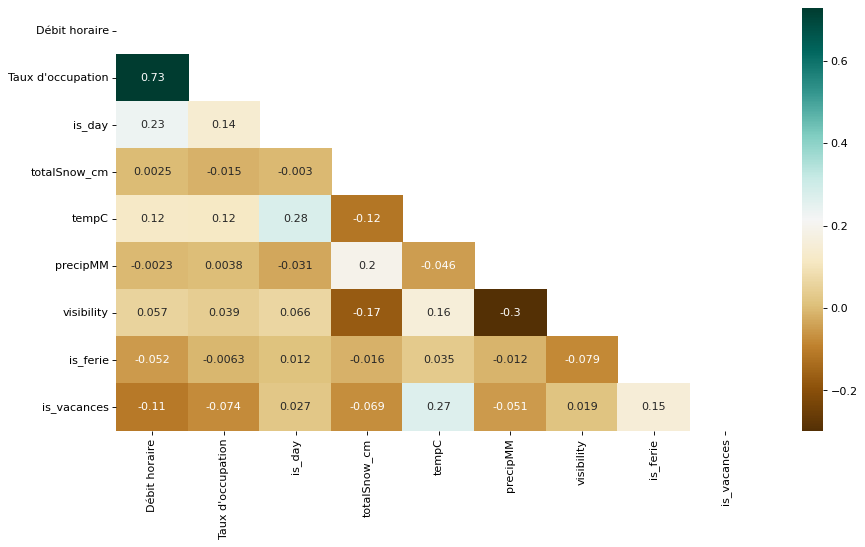

In [14]:
cor = data_train[["Débit horaire", "Taux d'occupation", "is_day", "totalSnow_cm", "tempC", "precipMM", "visibility", "is_ferie", "is_vacances"]].corr()
mask = np.triu(np.ones_like(cor))
plt.figure(figsize=(13, 7), dpi=80)
sns.heatmap(cor, mask = mask,  annot = True, cmap='BrBG')

### Tests d'algorithmes

Choisissons à présent l'algorithme. Nous allons choisir parmi RandomForest, XgBoost et RNN (GRU).

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 14, 50)            7950      
                                                                 
 dropout (Dropout)           (None, 14, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 23,352
Trainable params: 23,352
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
388/388 [==============================] 

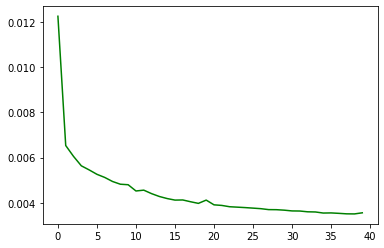

In [26]:
"""
    NN : GRU
"""

def gru_nn():
    model_nn = Sequential()
    #model_nn.add(GRU(units=150, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #model_nn.add(Dropout(0.2))
    model_nn.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    model_nn.add(Dropout(0.2))
    model_nn.add(GRU(units=50, input_shape=(X_train.shape[1],1), activation='tanh'))
    model_nn.add(Dropout(0.2))
    model_nn.add(Dense(2, kernel_initializer='normal', activation = "relu"))
    model_nn.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001), metrics = ['mean_squared_error'])
    model_nn.summary()

    return model_nn


model_nn = gru_nn()
history = model_nn.fit(X_train, y_train_nn, epochs = 40, batch_size = 64, verbose = 1)
plt.plot(history.epoch, history.history["loss"], 'g', label='Training loss')
plt.show()

In [22]:
"""
    RF et XGBoost
"""

rf = RandomForestRegressor(n_estimators = 300, max_depth = 10)
rf.fit(X_train, y_train)

xgb_to = XGBRegressor(n_estimators = 300, max_depth = 10)
xgb_to.fit(X_train, y_train["Taux d'occupation"])

xgb_dh = XGBRegressor(n_estimators = 300, max_depth = 10)
xgb_dh.fit(X_train, y_train["Débit horaire"])

##SAVE MODEL
"""
with open(path + 'rf_to.pickle', 'wb') as handle:
    pickle.dump(rf_to, handle, protocol=pickle.HIGHEST_PROTOCOL)
"""

[01:09:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:10:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


"\nwith open(path + 'rf_to.pickle', 'wb') as handle:\n    pickle.dump(rf_to, handle, protocol=pickle.HIGHEST_PROTOCOL)\n"

Les algorithmes ont été entrainés sur une partie du dataset (01/12/2021 à 31/12/2022). On peut tester leur performance sur jenvier 2023. 

Pour mieux se fixer les idées, on trace également leur prédiction et les vraies valeurs de janvier 2023.

In [23]:
def draw(data_test, pred, plot_curves = ["Débit horaire", "Taux d'occupation"]) :
    """
        Fonction pour tracer les prédictions et les vraies valeurs sur janvier 2023
    """
    
    n = len(list(data_test["Date et heure de comptage"]))

    to_concat = []

    if "Débit horaire" in plot_curves:
        df_dh = {"hour_number" : list(data_test["hour_number"]) ,"Type" : ["Débit horaire"]*n, "Values" : list(data_test["Débit horaire"]) }
        df_dh = pd.DataFrame.from_dict(df_dh)

        df_dh_pred = {"hour_number" : list(data_test["hour_number"]),"Type" : ["Débit horaire Pred"]*n, "Values" : pred[:,0] }
        df_dh_pred = pd.DataFrame.from_dict(df_dh_pred)

        to_concat.append(df_dh)
        to_concat.append(df_dh_pred)

    if "Taux d'occupation" in plot_curves:

        df_to = {"hour_number" : list(data_test["hour_number"]),"Type" : ["Taux d'occupation"]*n, "Values" : list(data_test["Taux d'occupation"]) }
        df_to = pd.DataFrame.from_dict(df_to)

        df_to_pred = {"hour_number" : list(data_test["hour_number"]),"Type" : ["Taux d'occupation Pred"]*n, "Values" : pred[:,1] }
        df_to_pred = pd.DataFrame.from_dict(df_to_pred)

        to_concat.append(df_to)
        to_concat.append(df_to_pred)


    pred_df = pd.concat(to_concat, ignore_index = True)

    plt.figure(figsize=(10, 5), dpi=80)

    sns.lineplot(data = pred_df, x="hour_number", y="Values", hue = "Type")
    #Plot Dimanche
    plt.axvline(0, 0, 1500, color = "red")
    plt.axvline(24*7, 0, 1500, color = "red")
    plt.axvline(24*7*2, 0, 1500, color = "red")
    plt.axvline(24*7*3, 0, 1500, color = "red")
    plt.axvline(24*7*4, 0, 1500, color = "red")





NEURAL NETWORK :
41/41 [==============================] - 2s 8ms/step
Root mean squared error (DH) : 88.73247236674361
Root mean squared error (TO) : 3.6692468882094804


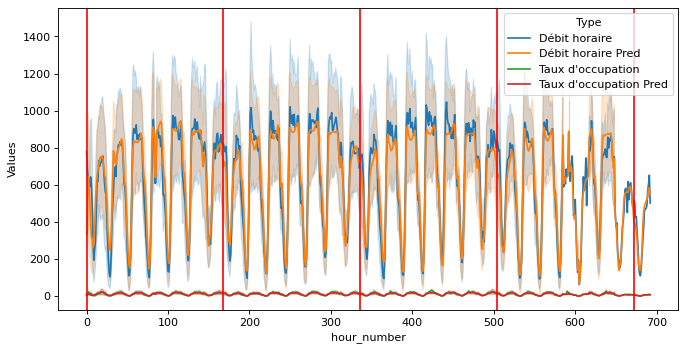

In [27]:
print("\nNEURAL NETWORK :")
pred = model_nn.predict(X_test)
#pred = scaler.inverse_transform(pred)
"""
def log_transform_inverse(x):
    return np.exp(x) - 1
np.vectorize(log_transform_inverse)
pred = log_transform_inverse(pred)
"""
pred[:,0] = pred[:,0]*maximums["Débit horaire"]
pred[:,1] = pred[:,1]*maximums["Taux d'occupation"]


print("Root mean squared error (DH) :" , np.sqrt( mean_squared_error(pred[:,0], y_test["Débit horaire"])  ) )
print("Root mean squared error (TO) :" , np.sqrt( mean_squared_error(pred[:,1], y_test["Taux d'occupation"])  ) )
draw(data_test, pred)


RANDOM FOREST :
Root mean squared error (DH) : 90.42150021776631
Root mean squared error (TO) : 4.240192270756951


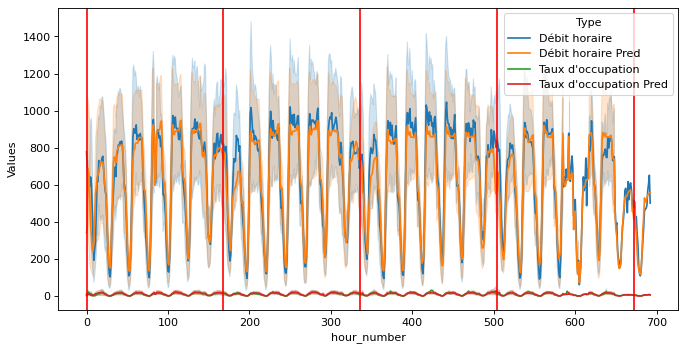

In [24]:
print("\nRANDOM FOREST :")

pred = rf.predict(X_test)

print("Root mean squared error (DH) :" , np.sqrt( mean_squared_error(pred[:,0], y_test["Débit horaire"])  ) )
print("Root mean squared error (TO) :" , np.sqrt( mean_squared_error(pred[:,1], y_test["Taux d'occupation"])  ) )
draw(data_test, pred)


XGBoost :
Root mean squared error (DH) : 105.09855361020136
Root mean squared error (TO) : 5.835448209927717


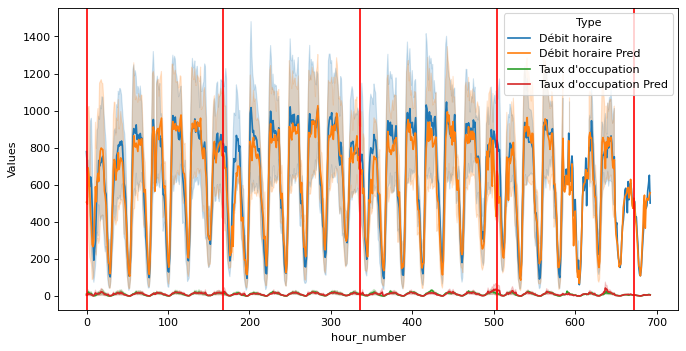

In [25]:
print("\nXGBoost :")

pred = np.stack((xgb_dh.predict(X_test), xgb_to.predict(X_test)), axis=-1)

print("Root mean squared error (DH) :" , np.sqrt( mean_squared_error(pred[:,0], y_test["Débit horaire"])  ) )
print("Root mean squared error (TO) :" , np.sqrt( mean_squared_error(pred[:,1], y_test["Taux d'occupation"])  ) )
draw(data_test, pred)

Le réseau de neurone semble plus performant. Nous optons pour ce choix d'algorithme.

### Hyperparamètre du NN

Il y a 2 grands hyperparamètres à tuner : le nombre d'époque et le taille des batch. Nous avons entrainé plusieurs algorithmes afin d'avoir une idée du meilleur couple (total epoch, batch_size) choisir.

In [ ]:
base_name = "model_gru_epoch_"
nb_epochs = 200

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}): #On ssauvegarde un modèle toutes les 10 époques
        if epoch > 0 and epoch%10 == 1:
            self.model.save(path + base_name + '{}.h5'.format(epoch))

for batch_size in [32,64,128,256] :
    saver = CustomSaver()
    model_nn = gru_nn()
    history = model_nn.fit(X_train, y_train_nn, epochs = nb_epochs, batch_size = batch_size, verbose = 1, callbacks=[saver])
    model_nn.save(path + 'model_gru_nn.h5') ##SAVE MODEL


    y_timeline = []
    X_timeline = []

    for i in range(1,nb_epochs + 1) :
        if i%10 == 1 :
            model_nn = load_model(path + base_name + str(i) + '.h5')
            pred = model_nn.predict(X_test)

            y_timeline.append( np.sqrt(mean_squared_error(pred[:,0], y_test_nn["Débit horaire"]) +  mean_squared_error(pred[:,1], y_test_nn["Taux d'occupation"]) ) )
            X_timeline.append(i)


    fig,ax = plt.subplots()

    ax.plot(history.epoch,
            history.history["loss"],
            color="red",
            marker="o")
    ax.set_xlabel("epoch", fontsize = 14)
    ax.set_ylabel("Training loss (RMSE)",
                    color="red",
                    fontsize=14)
    ax2 = ax.twinx()
    ax2.plot(X_timeline,y_timeline,color="green",marker="o")
    ax2.set_ylabel("Testing loss (RMSE)",color="green",fontsize=14)

    plt.savefig(path + "best_epochs_batchsize{}.png".format(batch_size), dpi = 200)

Le script ci-dessus a été lancé en dehors du notebook pour des raisons de rapditié. Voici néanmoins les résultats obtenus. Dans l'ordre, on a le graphe pour BATCH_SIZE = 256 puis 128 puis 64 puis 32.


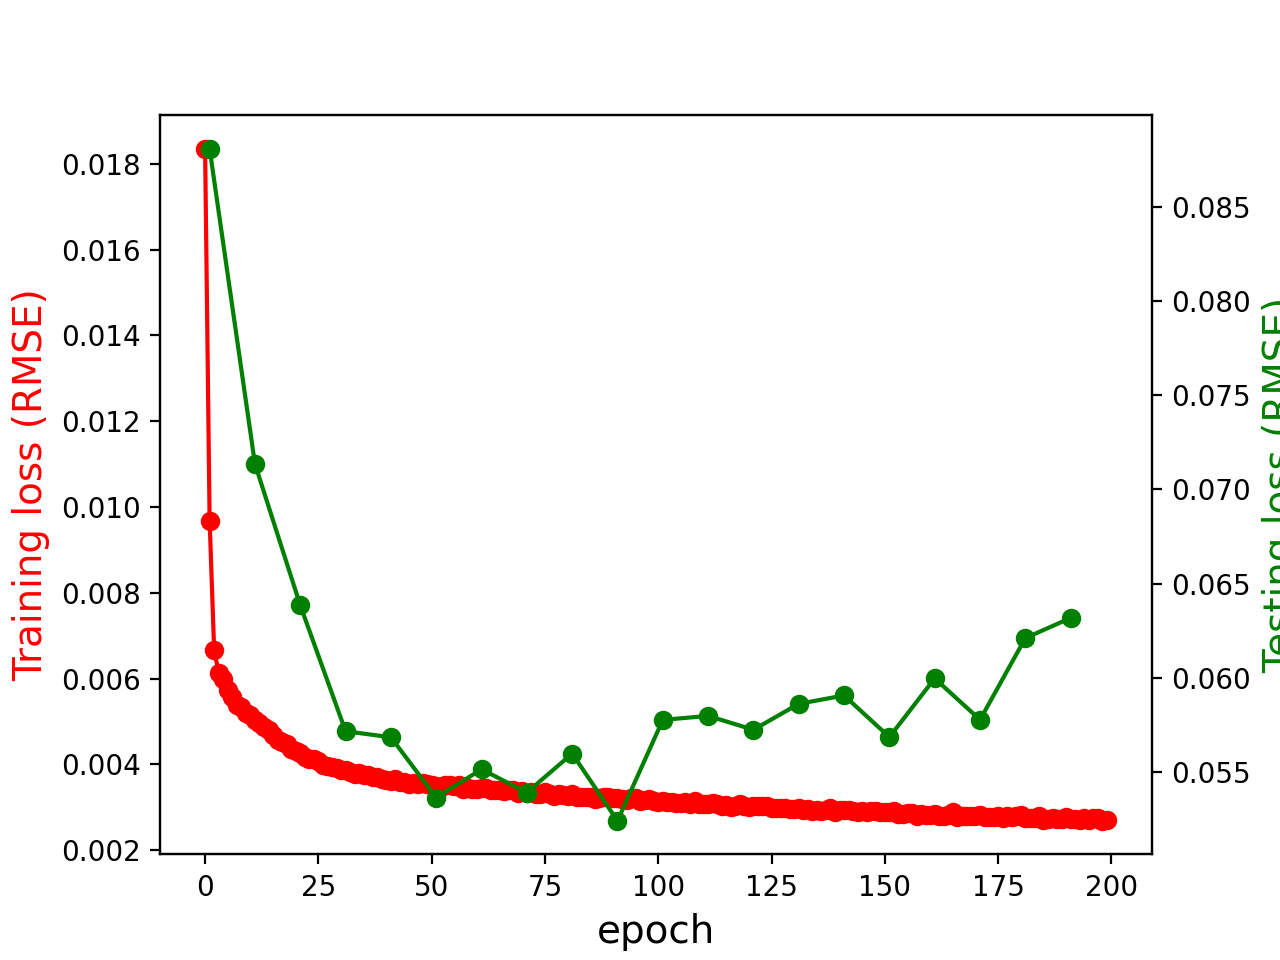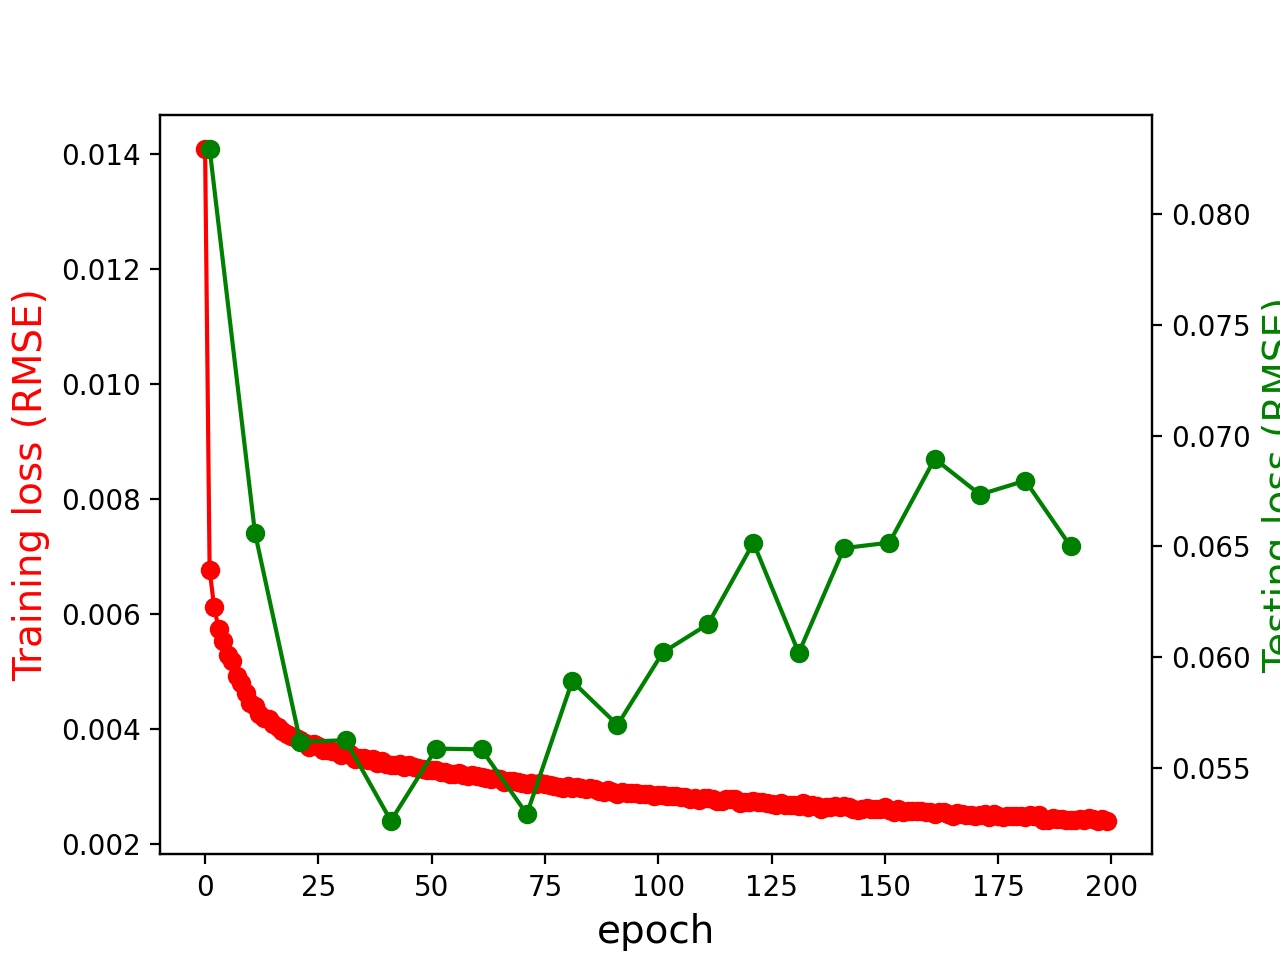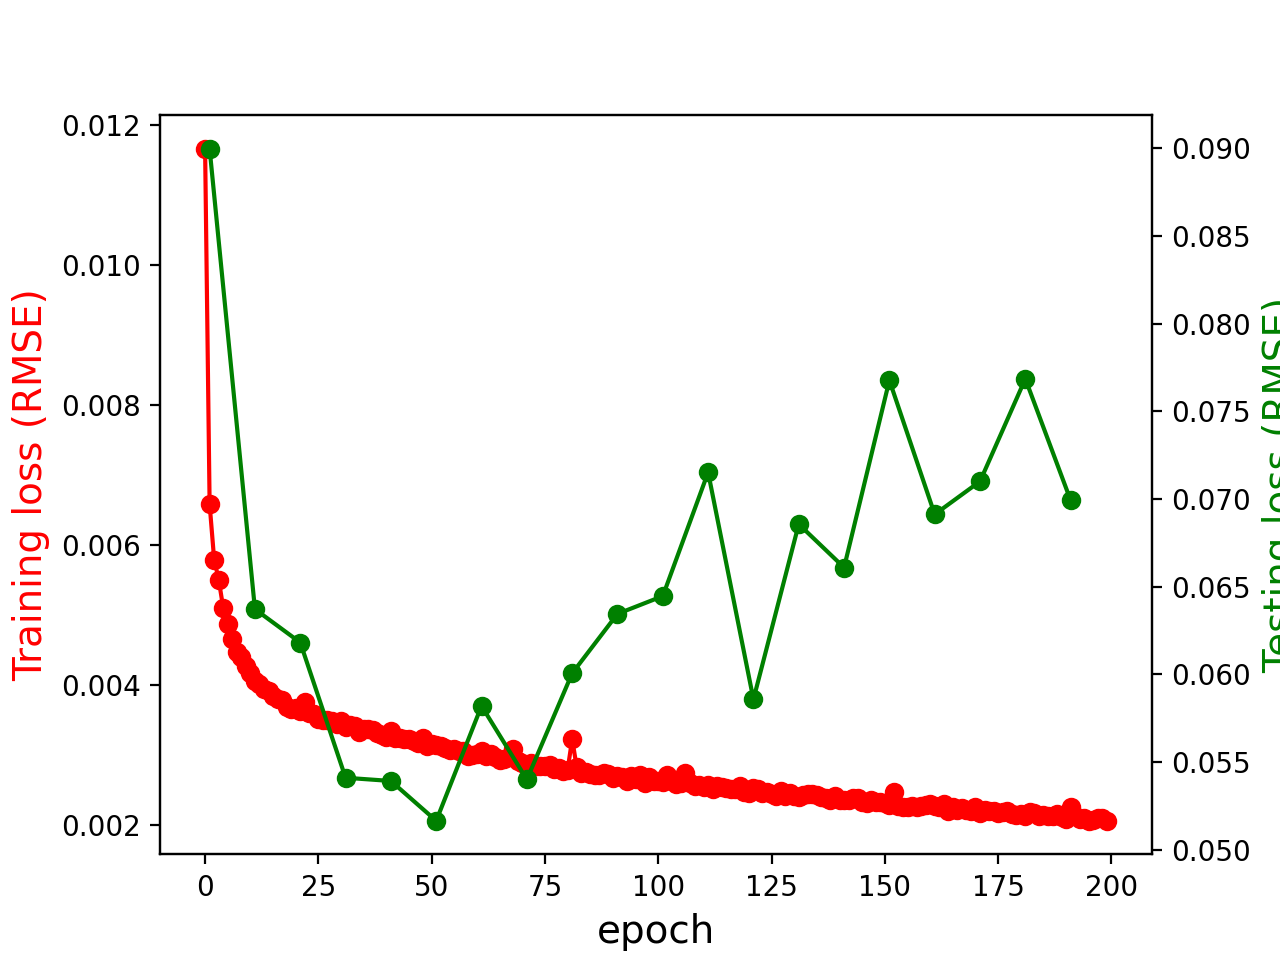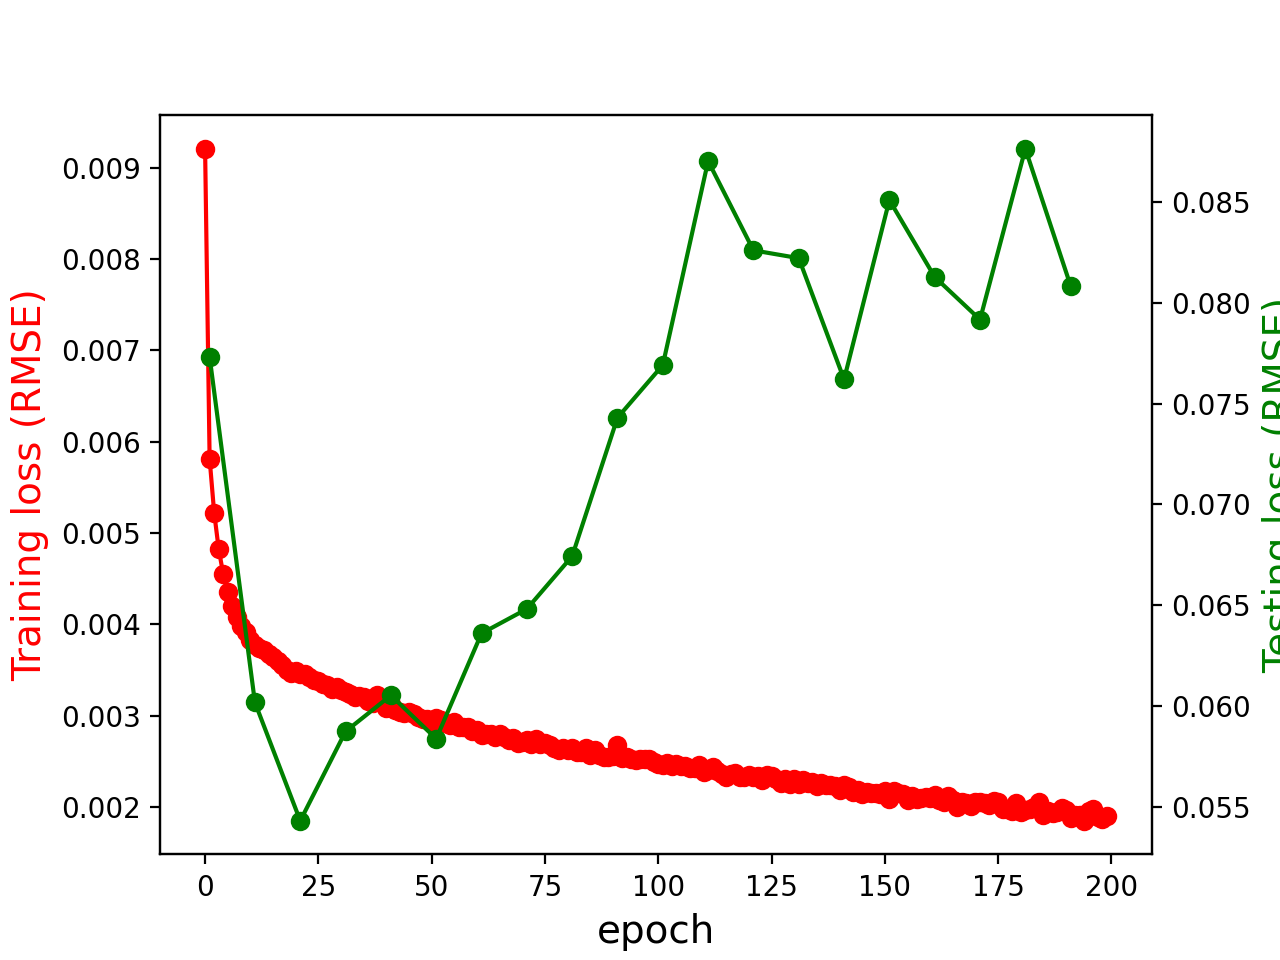

On constate que si la loss durant l'entrainement diminue continuellement, les performances sur le dataset de test se mettent tout d'abord à diminuer puis augmenter avec le nombre d'époque. En fait, dans un premier temps, le modèle apprend et donc améliore ses performances sur le dataset de test (la testing loss dimunue) mais si le modèle apprend trop, il y aura de l'overfitting et le modèle fait beaucoup moins bien lorsqu'il voit le dataset de test qu'il n'a jamais vu.

# TRAINING AND SUBMIT

Dorénavant, une fois que nous avons les features et l'algorithmes à utiliser, on peut entrainer sur l'intégralité des données (avec Janvier 2023) et prédire les 2 prochains jours.
On entraine pour de bon et on génère le CSV final

In [ ]:


def write_submission(model_type, start_date, end_date, filename = "submission.csv", features_to_keep = features_to_keep) :
    """
        Write the csv file for submission with predictions (using the trained model) from start_date to end_date
        model_type : "NN", "RF"
    """

    arc = "Champs-Elysées"

    #Creating X with features calculations
    date_list = []
    date_cur = datetime(year = start_date.year, month = start_date.month, day = start_date.day, hour=0, minute = 0, second = 0)
    end_date = datetime(year = end_date.year, month = end_date.month, day = end_date.day, hour=0, minute = 0, second = 0)

    while date_cur < end_date :
        date_list.append(date_cur)
        date_cur += timedelta(hours = 1)

    data_submission = {"Date et heure de comptage" : date_list }
    data_submission = pd.DataFrame.from_dict(data_submission)

    if "hour" in features_to_keep :
        data_submission["hour1"] = data_submission["Date et heure de comptage"].apply(t_hour_1)
        data_submission["hour2"] = data_submission["Date et heure de comptage"].apply(t_hour_2)

    if "weekdays" in features_to_keep :
        data_submission["weekdays1"] = data_submission["Date et heure de comptage"].apply(t_day_1)
        data_submission["weekdays2"] = data_submission["Date et heure de comptage"].apply(t_day_2)
    
    X = data_submission.drop(["Date et heure de comptage"], axis=1, inplace = False)

    if model_type == "NN" : #NN
        nn = load_model(path + 'model_gru4_nn.h5')

        pred = model_nn.predict(X_test)
        #pred = scaler.inverse_transform(pred)
        """
        def log_transform_inverse(x):
            return np.exp(x) - 1
        np.vectorize(log_transform_inverse)
        pred = log_transform_inverse(pred)
        """
        pred[:,0] = pred[:,0]*maximums["Débit horaire"]
        pred[:,1] = pred[:,1]*maximums["Taux d'occupation"]

    elif model_type == "RF" : #RF
        f_dh = open(path + 'rf_dh.pickle', 'rb')
        f_to = open(path + 'rf_to.pickle', 'rb')
        rf_dh = pickle.load(f_dh)
        rf_to = pickle.load(f_to)
        
        pred = np.stack((rf_dh.predict(X), rf_to.predict(X)), axis=-1)

        f_to.close()
        f_dh.close()


    with open(path + filename, 'w', newline='') as file:
        writer = csv.writer(file, delimiter=';')

        writer.writerow(["Arc", "Datetime", "Débit horaire", "Taux d'occupation"])

        cur = 0
        for index, row in data_submission.iterrows():
            writer.writerow([arc, row["Date et heure de comptage"], pred[cur,0], pred[cur,1]])
            cur += 1


write_submission(model_type = "NN", start_date = date(2023,1,29), end_date = date(2023,2,3) , filename = "submission.csv", features_to_keep = features_to_keep)

20/20 [==============================] - 0s 13ms/step
